Ivan Usachev   
usa0006

# Imports

In [35]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import NASNetLarge


In [3]:
# Check for GPU availability
if tf.test.gpu_device_name():
    print('GPU device found')
    print('Name:', tf.test.gpu_device_name())
else:
    print("No GPU found")

GPU device found
Name: /device:GPU:0


In [4]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i]])
    plt.show()

# Data loading

https://www.kaggle.com/datasets/trainingdatapro/gender-detection-and-classification-image-dataset

The dataset comprises a collection of photos of people, organized into folders labeled "women" and "men." The dataset contains a variety of images capturing female and male individuals from diverse. backgrounds, age groups, and ethnicities. Total number of photos is 300.

In [5]:
df = pd.read_csv('Data/gender_detection.csv')
df

,file,gender,split
0,train/women/0.jpg,woman,train
1,train/women/1.jpg,woman,train
2,train/women/2.jpg,woman,train
3,train/women/3.jpg,woman,train
4,train/women/4.jpg,woman,train
...,...,...,...
295,test/men/145.jpg,man,test
296,test/men/146.jpg,man,test
297,test/men/147.jpg,man,test
298,test/men/148.jpg,man,test


In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,file,gender,split
0,train/men/53.jpg,man,train
1,test/men/116.jpg,man,test
2,train/men/2.jpg,man,train
3,train/women/9.jpg,woman,train
4,train/men/83.jpg,man,train
...,...,...,...
295,train/men/38.jpg,man,train
296,train/women/71.jpg,woman,train
297,train/women/106.jpg,woman,train
298,test/men/120.jpg,man,test


# Data preprocessing
## Mapping classes to numeric values.

In [7]:
class_map = {'woman': 0, 'man': 1}  
df['class_value'] = df['gender'].map(class_map)
df

,file,gender,split,class_value
0,train/men/53.jpg,man,train,1
1,test/men/116.jpg,man,test,1
2,train/men/2.jpg,man,train,1
3,train/women/9.jpg,woman,train,0
4,train/men/83.jpg,man,train,1
...,...,...,...,...
295,train/men/38.jpg,man,train,1
296,train/women/71.jpg,woman,train,0
297,train/women/106.jpg,woman,train,0
298,test/men/120.jpg,man,test,1


In [8]:
class_counts = df['gender'].value_counts()
total_samples = len(df)
class_proportions = class_counts / total_samples

split_counts = df['split'].value_counts()
split_proportions = split_counts / total_samples

split_gender_counts = df.groupby(['split', 'gender']).size()
split_gender_proportions = split_gender_counts / df.groupby('split').size()

print("Overall class proportions:\n", class_proportions)
print("\nSplit proportions:\n", split_proportions)
print("\nProportions of each gender within each split:\n", split_gender_proportions)

Overall class proportions:
 gender
man      0.5
woman    0.5
Name: count, dtype: float64

Split proportions:
 split
train    0.733333
test     0.266667
Name: count, dtype: float64

Proportions of each gender within each split:
 split  gender
test   man       0.5
       woman     0.5
train  man       0.5
       woman     0.5
dtype: float64


The dataset is balanced, we should use accuracy metrics.

In [9]:
train_set = df[df['split'] == 'train']
test_set = df[df['split'] == 'test']

print(f"Train set size: {train_set.shape[0]}")
print(f"Test set size: {test_set.shape[0]}")

Train set size: 220
Test set size: 80


## Converting images to the RGB color space and resizing them to dimensions of 224x224

In [10]:
train_x = np.zeros((train_set.shape[0], 224, 224, 3))

for i in range(train_set.shape[0]):
    
    image = cv2.imread('Data/' + train_set["file"].values[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    train_x[i] = image / 255.0

train_y = np.array(train_set["class_value"])

In [11]:
test_x = np.zeros((test_set.shape[0], 224, 224, 3))

for i in range(test_set.shape[0]):
    
    image = cv2.imread('Data/' + test_set["file"].values[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    test_x[i] = image / 255.0

test_y = np.array(test_set["class_value"])

In [12]:
print('Train Data: ',train_x.shape)
print('Test Data: ',test_x.shape)

Train Data:  (220, 224, 224, 3)
Test Data:  (80, 224, 224, 3)


In [13]:
class_names = ['woman', 'man']
class_count = len(class_names)
class_count

2

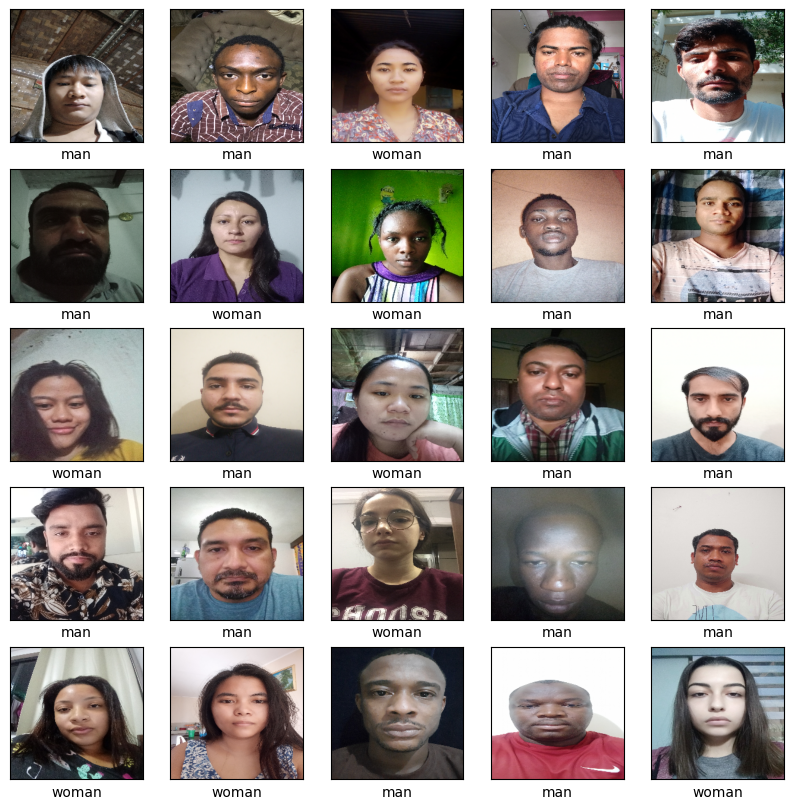

In [14]:
show_example(train_x, train_y, class_names)

# CNN Models
## Model from scratch

We should try model from scratch from the previous project first

In [41]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 111, 111, 64)      36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 55, 55, 64)       

In [42]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [43]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
44/44 [==============================] - 2s 22ms/step - loss: 0.6957 - binary_accuracy: 0.5511 - val_loss: 0.6939 - val_binary_accuracy: 0.4318
Epoch 2/10
44/44 [==============================] - 1s 14ms/step - loss: 0.7003 - binary_accuracy: 0.5227 - val_loss: 0.6980 - val_binary_accuracy: 0.4545
Epoch 3/10
44/44 [==============================] - 1s 14ms/step - loss: 0.7151 - binary_accuracy: 0.5795 - val_loss: 0.6939 - val_binary_accuracy: 0.4545
Epoch 4/10
44/44 [==============================] - 1s 14ms/step - loss: 0.6932 - binary_accuracy: 0.5114 - val_loss: 0.6945 - val_binary_accuracy: 0.4545
Epoch 5/10
44/44 [==============================] - 1s 14ms/step - loss: 0.6933 - binary_accuracy: 0.5114 - val_loss: 0.6943 - val_binary_accuracy: 0.4545
Epoch 6/10
44/44 [==============================] - 1s 14ms/step - loss: 0.6930 - binary_accuracy: 0.5114 - val_loss: 0.6945 - val_binary_accuracy: 0.4545
Epoch 7/10
44/44 [==============================] - 1s 14ms/step - los

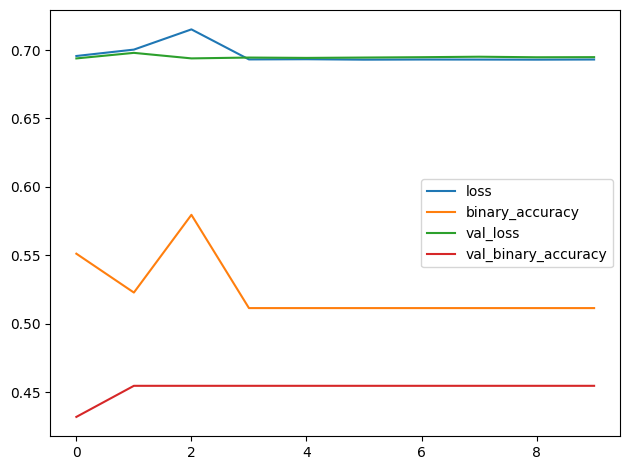

In [44]:
history=model.fit(train_x, train_y, epochs=10, validation_split=0.2, batch_size=4, callbacks=model_checkpoint_callback)
show_history(history)

In [45]:
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

3/3 [==============================] - 0s 41ms/step - loss: 0.6917 - binary_accuracy: 0.5125
Test accuracy:  0.512499988079071


This model doesnt work well with this dataset, we should try something else

In [46]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 109, 109, 16)      4624      
_________________________________________________________________
flatten_6 (Flatten)          (None, 190096)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                12166208  
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 12,171,793
Trainable params: 12,171,793
Non-trainable params: 0
__________________________________________

In [47]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [48]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
44/44 [==============================] - 1s 16ms/step - loss: 1.0194 - binary_accuracy: 0.4602 - val_loss: 0.6928 - val_binary_accuracy: 0.5000
Epoch 2/10
44/44 [==============================] - 0s 7ms/step - loss: 0.6915 - binary_accuracy: 0.7159 - val_loss: 0.6817 - val_binary_accuracy: 0.5455
Epoch 3/10
44/44 [==============================] - 0s 7ms/step - loss: 0.6219 - binary_accuracy: 0.6875 - val_loss: 0.6599 - val_binary_accuracy: 0.6364
Epoch 4/10
44/44 [==============================] - 0s 7ms/step - loss: 0.3124 - binary_accuracy: 0.8807 - val_loss: 1.3148 - val_binary_accuracy: 0.5682
Epoch 5/10
44/44 [==============================] - 0s 7ms/step - loss: 0.5919 - binary_accuracy: 0.8409 - val_loss: 0.6207 - val_binary_accuracy: 0.6591
Epoch 6/10
44/44 [==============================] - 0s 7ms/step - loss: 0.3624 - binary_accuracy: 0.9091 - val_loss: 0.9414 - val_binary_accuracy: 0.6136
Epoch 7/10
44/44 [==============================] - 0s 7ms/step - loss: 0.1

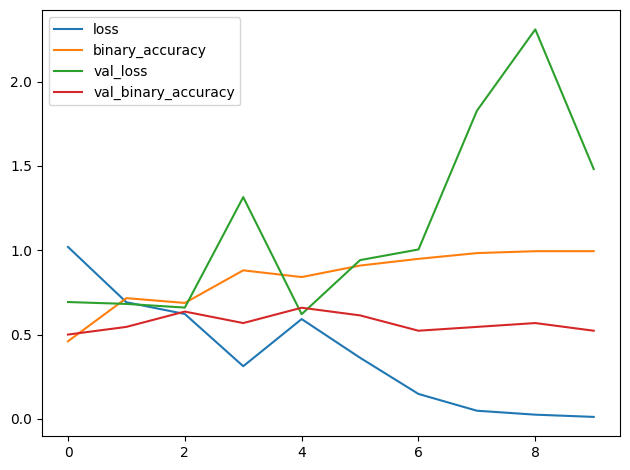

In [49]:
history=model.fit(train_x, train_y, epochs=10, validation_split=0.2, batch_size=4, callbacks=model_checkpoint_callback)
show_history(history)

In [50]:
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

3/3 [==============================] - 0s 17ms/step - loss: 0.7510 - binary_accuracy: 0.6000
Test accuracy:  0.6000000238418579


This model showed better results than the model from previous project, but it is overfitted at the beginning. Lets add some more layers and Dropout layer

In [66]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 52, 52, 128)     

In [67]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())


In [68]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
44/44 [==============================] - 1s 15ms/step - loss: 1.0739 - binary_accuracy: 0.5398 - val_loss: 0.7217 - val_binary_accuracy: 0.4545
Epoch 2/10
44/44 [==============================] - 0s 10ms/step - loss: 0.6967 - binary_accuracy: 0.4886 - val_loss: 0.6934 - val_binary_accuracy: 0.4545
Epoch 3/10
44/44 [==============================] - 0s 10ms/step - loss: 0.6937 - binary_accuracy: 0.5568 - val_loss: 0.6935 - val_binary_accuracy: 0.4545
Epoch 4/10
44/44 [==============================] - 0s 10ms/step - loss: 0.6935 - binary_accuracy: 0.5625 - val_loss: 0.6921 - val_binary_accuracy: 0.4773
Epoch 5/10
44/44 [==============================] - 0s 10ms/step - loss: 0.6953 - binary_accuracy: 0.5511 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 6/10
44/44 [==============================] - 0s 10ms/step - loss: 0.6851 - binary_accuracy: 0.6193 - val_loss: 0.6477 - val_binary_accuracy: 0.6591
Epoch 7/10
44/44 [==============================] - 0s 10ms/step - los

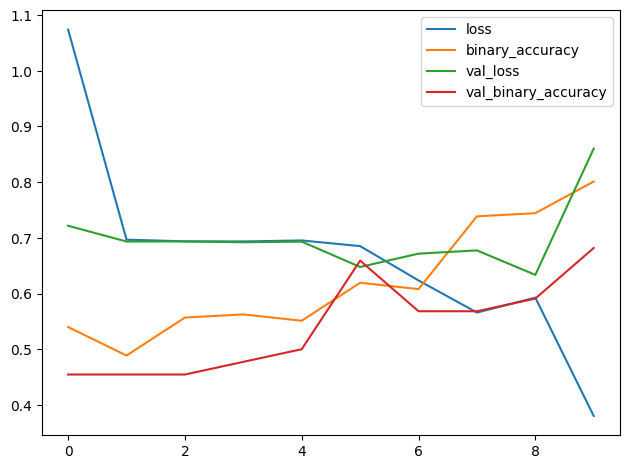

In [69]:
history=model.fit(train_x, train_y, epochs=10, validation_split=0.2, batch_size=4, callbacks=model_checkpoint_callback)
show_history(history)

In [70]:
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

3/3 [==============================] - 0s 29ms/step - loss: 0.6636 - binary_accuracy: 0.6625
Test accuracy:  0.6625000238418579


This model is a little bit better, but it is still overfitted. Lets add BatchNormalization layer and try more epochs

In [30]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 111, 64)      256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 55, 55, 64)       

In [31]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [32]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
44/44 [==============================] - 2s 19ms/step - loss: 1.0288 - binary_accuracy: 0.5341 - val_loss: 1.4519 - val_binary_accuracy: 0.4545
Epoch 2/20
44/44 [==============================] - 1s 14ms/step - loss: 0.6835 - binary_accuracy: 0.5909 - val_loss: 2.5913 - val_binary_accuracy: 0.3864
Epoch 3/20
44/44 [==============================] - 1s 14ms/step - loss: 0.5709 - binary_accuracy: 0.6989 - val_loss: 1.7565 - val_binary_accuracy: 0.4318
Epoch 4/20
44/44 [==============================] - 1s 14ms/step - loss: 0.5671 - binary_accuracy: 0.7102 - val_loss: 0.7741 - val_binary_accuracy: 0.5455
Epoch 5/20
44/44 [==============================] - 1s 14ms/step - loss: 0.5985 - binary_accuracy: 0.6875 - val_loss: 0.8724 - val_binary_accuracy: 0.5227
Epoch 6/20
44/44 [==============================] - 1s 14ms/step - loss: 0.5899 - binary_accuracy: 0.6989 - val_loss: 0.8384 - val_binary_accuracy: 0.5455
Epoch 7/20
44/44 [==============================] - 1s 14ms/step - los

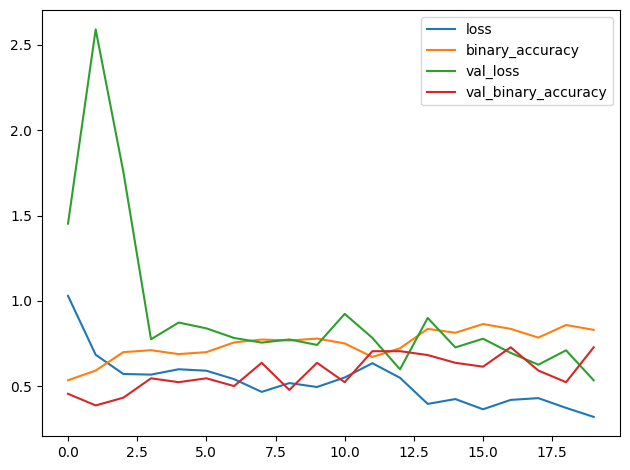

In [33]:
history=model.fit(train_x, train_y, epochs=20, validation_split=0.2, batch_size=4, callbacks=model_checkpoint_callback)
show_history(history)


In [34]:
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

3/3 [==============================] - 0s 33ms/step - loss: 0.6418 - binary_accuracy: 0.7125
Test accuracy:  0.7124999761581421


## ResNet50
### Data preprocessing for ResNet50 and MobileNetV2 Models

In [71]:
train_x = np.zeros((train_set.shape[0], 224, 224, 3))

for i in range(train_set.shape[0]):
    
    image = cv2.imread('Data/' + train_set["file"].values[i])
    image = cv2.resize(image, (224,224))
    train_x[i] = image 

test_x = np.zeros((test_set.shape[0], 224, 224, 3))

for i in range(test_set.shape[0]):
    
    image = cv2.imread('Data/' + test_set["file"].values[i])
    image = cv2.resize(image, (224,224))
    test_x[i] = image 

train_y = np.array(train_set["class_value"])
test_y = np.array(test_set["class_value"])

In [72]:
base_model = ResNet50(
    weights='imagenet', 
    input_shape=(224, 224, 3),
    include_top=False) 

In [73]:
base_model.trainable = False

In [74]:
inputs = keras.Input(shape=(224, 224, 3), dtype=tf.uint8)
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [75]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [76]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
44/44 [==============================] - 6s 42ms/step - loss: 0.6443 - binary_accuracy: 0.6420 - val_loss: 0.4694 - val_binary_accuracy: 0.7727
Epoch 2/10
44/44 [==============================] - 1s 19ms/step - loss: 0.3669 - binary_accuracy: 0.8864 - val_loss: 0.3736 - val_binary_accuracy: 0.8409
Epoch 3/10
44/44 [==============================] - 1s 19ms/step - loss: 0.2857 - binary_accuracy: 0.9261 - val_loss: 0.3611 - val_binary_accuracy: 0.8182
Epoch 4/10
44/44 [==============================] - 1s 19ms/step - loss: 0.2215 - binary_accuracy: 0.9489 - val_loss: 0.3361 - val_binary_accuracy: 0.8864
Epoch 5/10
44/44 [==============================] - 1s 19ms/step - loss: 0.1778 - binary_accuracy: 0.9602 - val_loss: 0.3263 - val_binary_accuracy: 0.8636
Epoch 6/10
44/44 [==============================] - 1s 19ms/step - loss: 0.1488 - binary_accuracy: 0.9545 - val_loss: 0.3382 - val_binary_accuracy: 0.8636
Epoch 7/10
44/44 [==============================] - 1s 19ms/step - los

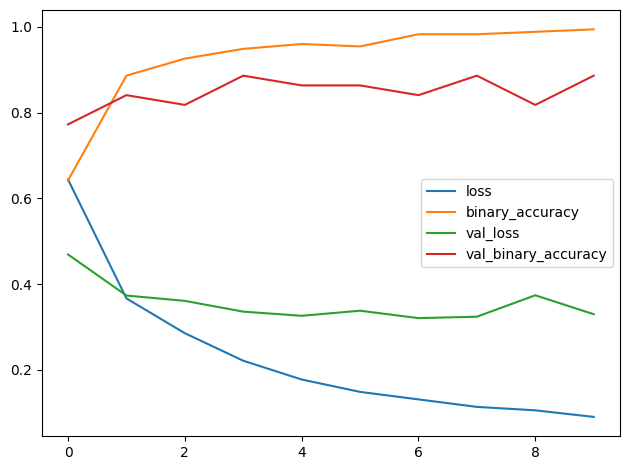

In [77]:
history=model.fit(train_x, train_y, epochs=10, validation_split=0.2, batch_size=4, callbacks=model_checkpoint_callback)
show_history(history)

In [78]:
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

3/3 [==============================] - 3s 406ms/step - loss: 0.3809 - binary_accuracy: 0.8000
Test accuracy:  0.800000011920929


## MobileNetV2

In [79]:
base_model = MobileNetV2(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)  

In [80]:
base_model.trainable = False

In [81]:
inputs = keras.Input(shape=(224, 224, 3), dtype=tf.uint8)
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [82]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [83]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
44/44 [==============================] - 5s 30ms/step - loss: 0.6674 - binary_accuracy: 0.5795 - val_loss: 0.5950 - val_binary_accuracy: 0.5909
Epoch 2/10
44/44 [==============================] - 0s 10ms/step - loss: 0.4876 - binary_accuracy: 0.7727 - val_loss: 0.5307 - val_binary_accuracy: 0.7045
Epoch 3/10
44/44 [==============================] - 0s 11ms/step - loss: 0.3934 - binary_accuracy: 0.8295 - val_loss: 0.5303 - val_binary_accuracy: 0.7727
Epoch 4/10
44/44 [==============================] - 0s 11ms/step - loss: 0.3349 - binary_accuracy: 0.8636 - val_loss: 0.4598 - val_binary_accuracy: 0.7955
Epoch 5/10
44/44 [==============================] - 0s 11ms/step - loss: 0.2862 - binary_accuracy: 0.9034 - val_loss: 0.4393 - val_binary_accuracy: 0.7955
Epoch 6/10
44/44 [==============================] - 0s 11ms/step - loss: 0.2582 - binary_accuracy: 0.9261 - val_loss: 0.4349 - val_binary_accuracy: 0.7955
Epoch 7/10
44/44 [==============================] - 0s 10ms/step - los

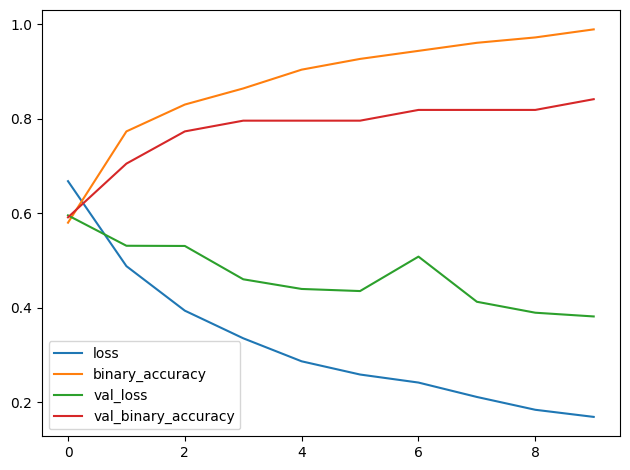

In [84]:
history=model.fit(train_x, train_y, epochs=10, validation_split=0.2, batch_size=4, callbacks=model_checkpoint_callback)
show_history(history)

In [85]:
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

3/3 [==============================] - 2s 217ms/step - loss: 0.4219 - binary_accuracy: 0.8000
Test accuracy:  0.800000011920929


## NASNetLarge
### Data preprocessing for NASNetLarge Model

In [86]:
train_x = np.zeros((train_set.shape[0], 331, 331, 3))

for i in range(train_set.shape[0]):
    
    image = cv2.imread('Data/' + train_set["file"].values[i])
    image = cv2.resize(image, (331,331))
    train_x[i] = image 

test_x = np.zeros((test_set.shape[0], 331, 331, 3))

for i in range(test_set.shape[0]):
    
    image = cv2.imread('Data/' + test_set["file"].values[i])
    image = cv2.resize(image, (331,331))
    test_x[i] = image 

train_y = np.array(train_set["class_value"])
test_y = np.array(test_set["class_value"])

In [87]:
base_model = NASNetLarge(
    weights='imagenet',  
    input_shape=(331, 331, 3),
    include_top=False)  

In [88]:
base_model.trainable = False

In [89]:
from tensorflow.keras.applications.nasnet import preprocess_input

inputs = keras.Input(shape=(331, 331, 3), dtype=tf.uint8)
x = tf.cast(inputs, tf.float32)
x = preprocess_input(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [90]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [91]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
44/44 [==============================] - 36s 295ms/step - loss: 0.5382 - binary_accuracy: 0.7614 - val_loss: 0.4431 - val_binary_accuracy: 0.7955
Epoch 2/10
44/44 [==============================] - 6s 130ms/step - loss: 0.3251 - binary_accuracy: 0.8920 - val_loss: 0.3736 - val_binary_accuracy: 0.8409
Epoch 3/10
44/44 [==============================] - 6s 131ms/step - loss: 0.2508 - binary_accuracy: 0.9261 - val_loss: 0.3443 - val_binary_accuracy: 0.8409
Epoch 4/10
44/44 [==============================] - 6s 131ms/step - loss: 0.2005 - binary_accuracy: 0.9432 - val_loss: 0.3474 - val_binary_accuracy: 0.8409
Epoch 5/10
44/44 [==============================] - 6s 132ms/step - loss: 0.1621 - binary_accuracy: 0.9773 - val_loss: 0.3384 - val_binary_accuracy: 0.8182
Epoch 6/10
44/44 [==============================] - 6s 132ms/step - loss: 0.1390 - binary_accuracy: 0.9773 - val_loss: 0.3333 - val_binary_accuracy: 0.8182
Epoch 7/10
44/44 [==============================] - 6s 131ms/st

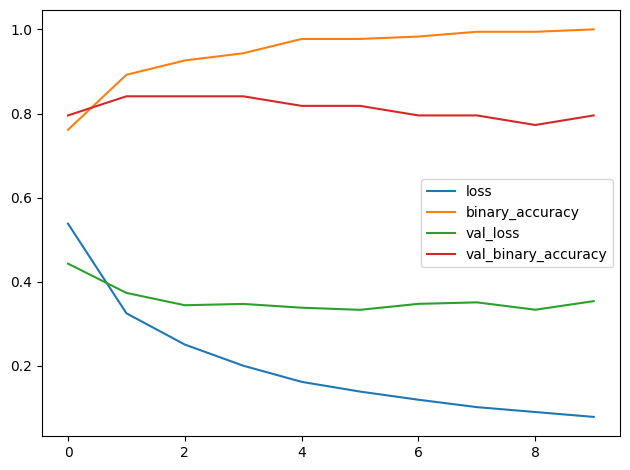

In [92]:
history=model.fit(train_x, train_y, epochs=10, validation_split=0.2, batch_size=4, callbacks=model_checkpoint_callback)
show_history(history)

In [93]:
model.load_weights("weights.best.hdf5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

3/3 [==============================] - 12s 1s/step - loss: 0.3255 - binary_accuracy: 0.8500
Test accuracy:  0.8500000238418579


# Summary

Four models were tested: a model built from scratch, ResNet50, MobileNetV2 and NASNetLarge model. The NASNetLarge model demonstrated the best performance among all four models, although it had a slow training process. The second-best performers were the ResNet50 and the MobileNetV2 models, which had similar results. The scratch model did not achieve the best performance but it became the best model made by author of this project.